In [2]:
!pip install mediapipe --user

  Using cached mediapipe-0.10.14-cp311-cp311-win_amd64.whl.metadata (9.9 kB)
  Using cached jax-0.4.28-py3-none-any.whl.metadata (23 kB)
  Using cached jaxlib-0.4.28-cp311-cp311-win_amd64.whl.metadata (1.8 kB)
  Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl.metadata (20 kB)
  Using cached sounddevice-0.4.7-py3-none-win_amd64.whl.metadata (1.4 kB)
Using cached mediapipe-0.10.14-cp311-cp311-win_amd64.whl (50.8 MB)
Using cached sounddevice-0.4.7-py3-none-win_amd64.whl (200 kB)
Using cached jax-0.4.28-py3-none-any.whl (1.9 MB)
Using cached jaxlib-0.4.28-cp311-cp311-win_amd64.whl (51.5 MB)
Using cached opencv_contrib_python-4.9.0.80-cp37-abi3-win_amd64.whl (45.3 MB)


In [49]:
import tensorflow as tf
import cv2

from tensorflow.keras.applications import MobileNetV2 
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras import Model
from pickle import load

In [37]:
def create_model(input_shape, output_shape):
    inputs = tf.keras.Input(shape=input_shape)
    feature_extractor = MobileNetV2(
        include_top=False,
        weights='imagenet',
        input_shape=(128,128,3)
    )
    extracted_features = feature_extractor(inputs, training=True)
    gap = GlobalAveragePooling2D()(extracted_features)
    fc2 = Dense(output_shape, activation="softmax")(gap)
    
    model = Model(inputs=inputs, outputs=fc2)
    model.compile(optimizer="adam", loss="categorical_crossentropy", metrics=['accuracy'])
    return model

In [51]:
new_model = create_model(
  input_shape=(128, 128, 3),
  output_shape=3
)
new_model.load_weights("../models/my_model_weights.weights.h5")
label_decoder = load(open("../models/facial_expr_label_encoder.pkl", "rb"))


In [13]:
import mediapipe as mp
import matplotlib.pyplot as plt
import numpy as np

In [4]:
BaseOptions = mp.tasks.BaseOptions
FaceDetector = mp.tasks.vision.FaceDetector
FaceDetectorOptions = mp.tasks.vision.FaceDetectorOptions
VisionRunningMode = mp.tasks.vision.RunningMode


options = FaceDetectorOptions(
    base_options=BaseOptions(
      model_asset_path='../models/blaze_face_short_range.tflite'
    ),
    running_mode=VisionRunningMode.IMAGE)

In [54]:
with FaceDetector.create_from_options(options) as detector:
  mp_image = mp.Image.create_from_file('../visualizer/core/test/frame_0003.png')
  face_detector_result = detector.detect(mp_image)
  print(face_detector_result.detections)

[Detection(bounding_box=BoundingBox(origin_x=573, origin_y=233, width=363, height=363), categories=[Category(index=0, score=0.9414109587669373, display_name=None, category_name=None)], keypoints=[NormalizedKeypoint(x=0.5310010313987732, y=0.46102339029312134, label='', score=0.0), NormalizedKeypoint(x=0.6518800258636475, y=0.45390498638153076, label='', score=0.0), NormalizedKeypoint(x=0.5965259075164795, y=0.5721991658210754, label='', score=0.0), NormalizedKeypoint(x=0.597130298614502, y=0.6790992617607117, label='', score=0.0), NormalizedKeypoint(x=0.4606316089630127, y=0.5227519273757935, label='', score=0.0), NormalizedKeypoint(x=0.7158049941062927, y=0.507344663143158, label='', score=0.0)])]


c:\Users\patel\anaconda3\Lib\site-packages\google\protobuf\symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
[['neutral']]


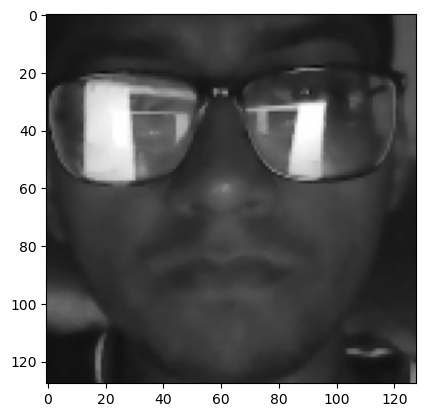

In [56]:
for detection in face_detector_result.detections:
  bounding_box = detection.bounding_box
  image_np = mp_image.numpy_view()
  image_np = image_np[
    bounding_box.origin_y:bounding_box.origin_y+bounding_box.height,
    bounding_box.origin_x:bounding_box.origin_x+bounding_box.width,
  ]
  image_np = cv2.resize(image_np, (128, 128), cv2.INTER_NEAREST)
  image_np = cv2.cvtColor(image_np, cv2.COLOR_BGR2GRAY)
  image_np = np.expand_dims(image_np, axis=2)
  image_np = np.repeat(image_np,3, axis=2)
  image_np = np.array([image_np])
  prediction = new_model.predict(image_np)
  prediction_label = label_decoder.inverse_transform(prediction)
  print(prediction_label)
  
  
  plt.imshow(image_np.squeeze())
  plt.show()
  break

In [31]:
image_np = mp_image.numpy_view()
image_np.shape

(720, 1280, 3)